In [34]:
import numpy as np
from numpy.linalg import det
from numpy import cov, corrcoef
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
import metatensor
import ase
import pickle
import ase.io
import chemiscope
from anisoap.utils import ClebschGordanReal, cg_combine, standardize_keys
from skmatter.preprocessing import StandardFlexibleScaler
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN
from benzene_finder_from_tags import get_benzene_carbons
from data_reader import read_tagged_xyz

In [35]:
with open("output/anisoap_vectors.pickle", "rb") as f:
    rep_raw = pickle.load(f)

xtals = ase.io.read("output/benzene_xtals.xyz", ":")
ells = ase.io.read("output/benzene_ell_frames.xyz", ":")

for ell in ells:
    ell.arrays.update({"c_diameter[1]": ell.arrays["c_diameter1"]})
    ell.arrays.update({"c_diameter[2]": ell.arrays["c_diameter2"]})
    ell.arrays.update({"c_diameter[3]": ell.arrays["c_diameter3"]})

lmax, nmax, gaussian, cutoff_radius = 9, 6, 1.5, 7.0
mycg = ClebschGordanReal(lmax)

ANISOAP_HYPERS = {
    "max_angular": lmax,
    "max_radial": nmax,
    "radial_basis_name": "gto",
    "rotation_type": "quaternion",
    "rotation_key": "quaternions",
    "radial_gaussian_width": gaussian,
    "cutoff_radius": cutoff_radius,
    "basis_rcond": 1e-8,
    "basis_tol": 1e-4,
}

In [36]:
aniso_nu1 = standardize_keys(rep_raw)
aniso_nu2 = cg_combine(
    aniso_nu1,
    aniso_nu1,
    clebsch_gordan=mycg,
    lcut=0,
    other_keys_match=["types_center"],
)
rep = metatensor.operations.mean_over_samples(aniso_nu2, sample_names="center")
x_raw = rep.block().values.squeeze()
x_scaler_train = StandardFlexibleScaler(column_wise=False).fit(x_raw)
x_train = x_scaler_train.transform(x_raw)

/home/lucasortengren/miniforge3/envs/ocsp/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/lucasortengren/miniforge3/envs/ocsp/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [37]:
np.shape(x_train)

(627, 490)

In [38]:
# manually determined packing motifs
packing_motifs = dict(
    WOGMIQ="HB",
    PENCEN="HB",
    QNACRD03="beta",
    # SAGLAQ="brickwork",
    HETPAL="beta",
    SABMAL="HB",
    CUBTEA="HB",
    HEXFUL="beta",
    MXPACX="gamma",
    BENZAC19="gamma",
    HAXPAX="gamma",
    PAVCUM="beta",
    HYQUIN="gamma",
    NALXOP="beta",
    DAVRIE="beta",
    MUMZEA="sandwich",
    NITPOL09="gamma",
    JACPOS01="gamma",
    DUJQOP="beta",
    IQEYUZ="beta",
    XOQBEK="HB",
    JOKVOW="beta",
    RAJDEM="beta",
    VIRGOS01="HB",
    UWUFAV="gamma",
)

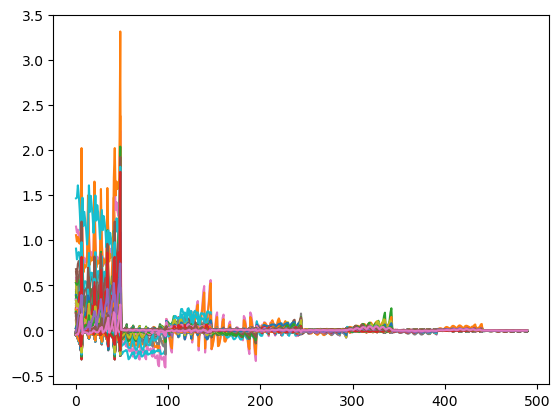

In [39]:
plt.plot(x_train.T)
plt.show()

In [40]:
mols = read_tagged_xyz("data/all_relaxed_molecules_tagged.xyz", "data/all_relaxed_molecules.xyz")
bcs_only = get_benzene_carbons(xtals, mols)

In [41]:
df = pd.DataFrame()

pca = PCA(n_components=3)
pcs = pca.fit_transform(x_train)
df["pc1"] = pcs[:, 0]
df["pc2"] = pcs[:, 1]
df["pc3"] = pcs[:, 2]

df["CCDC_ID"] = [xtal.info["CCDC_ID"] for xtal in xtals]
df["ell_count"] = [len(xtal) for xtal in ells]
df["cell_size"] = [det(xtal.get_cell()) for xtal in ells]
df["ell_density"] = df["ell_count"] / df["cell_size"]

In [42]:
df

pc1       pc2       pc3 CCDC_ID  ell_count    cell_size  ell_density
0   -0.076895  0.407011  0.354141  WOGMIQ          4   859.485052     0.004654
1    4.454241  1.747346 -0.375886  PENCEN         10   692.383758     0.014443
2   -0.072705  0.230621 -0.139242  YANFAX          4   810.120596     0.004938
3   -0.533056 -0.139601 -0.115434  SAGLAQ          2   762.103290     0.002624
4   -0.565710 -0.044505  0.196054  QIHPUS          4  1249.416331     0.003201
..        ...       ...       ...     ...        ...          ...          ...
622 -0.392003 -0.166445 -0.024132  JECYUM          4   884.909305     0.004520
623 -0.361024 -0.330107  0.113164  ZOYCOH          4  1043.764804     0.003832
624  1.631762  0.587126 -0.415540  PUSYIM         10   947.969745     0.010549
625  0.289363  0.153752 -0.389234  HYQUIN          4   529.720921     0.007551
626  0.334360  0.475498 -0.111939  LONMAD          6  1305.960843     0.004594

[627 rows x 7 columns]

In [43]:
hdb = HDBSCAN(min_cluster_size=5, min_samples=3, cluster_selection_epsilon=0.097)
class_tags = hdb.fit_predict(x_train)
df["HDB_class"] = class_tags
print("samples not classified as noisy: ", np.shape(df[df["HDB_class"] != -1]))
print("number of classes: ", len(df["HDB_class"].unique()))

samples not classified as noisy:  (249, 8)
number of classes:  21


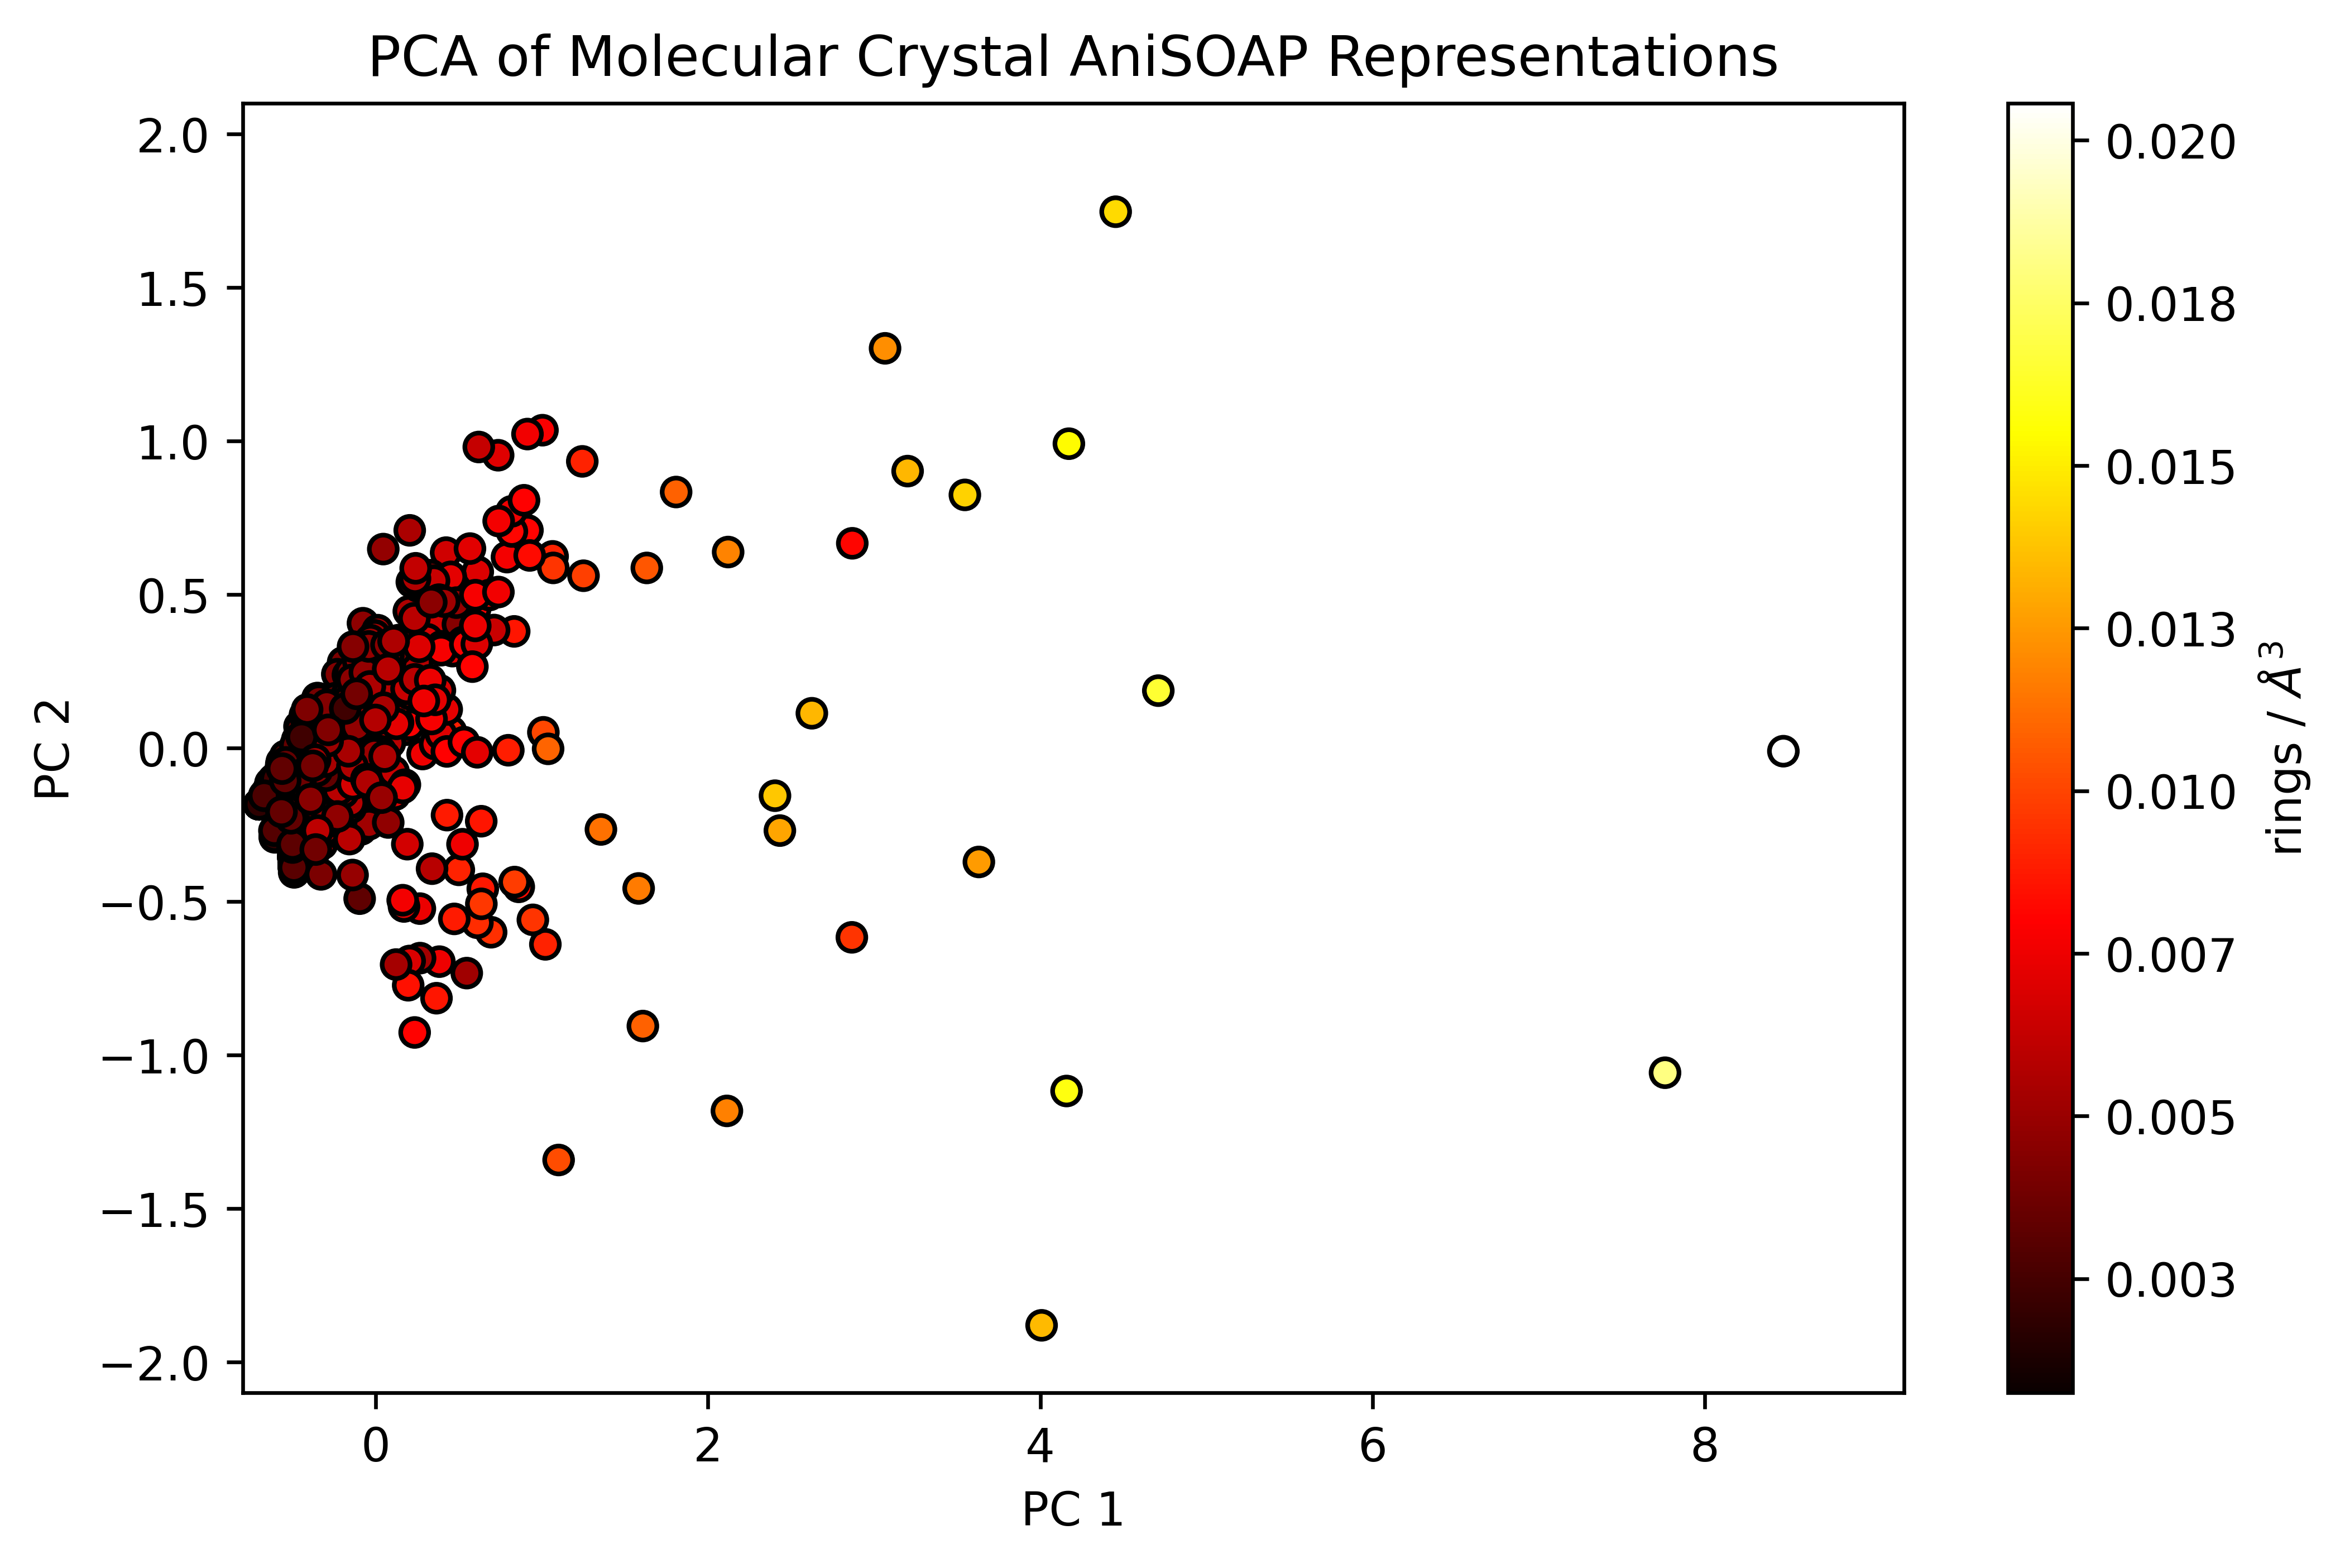

In [57]:
fig, ax = plt.subplots()
sc = ax.scatter(df["pc1"], df["pc2"], c=df["ell_density"], cmap="hot", edgecolors="black")
#ax.set_xscale("log")
ax.set_xlim((-0.8, 9.2))
ax.set_ylim((-2.1, 2.1))
fig.set_size_inches(8, 5)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
fig.colorbar(sc, ax=ax, label=r"rings / $Å^3$", format="%.3f")
ax.set_title("PCA of Molecular Crystal AniSOAP Representations")
fig.set_dpi(600)
plt.show()
fig.savefig("mol_xtal_pca_wide.png")

In [48]:
non_noise = df[df["HDB_class"] != -1]
noise = df[df["HDB_class"] == -1]
print(len(noise))
print(len(non_noise))

378
249


/tmp/ipykernel_13936/1144520977.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


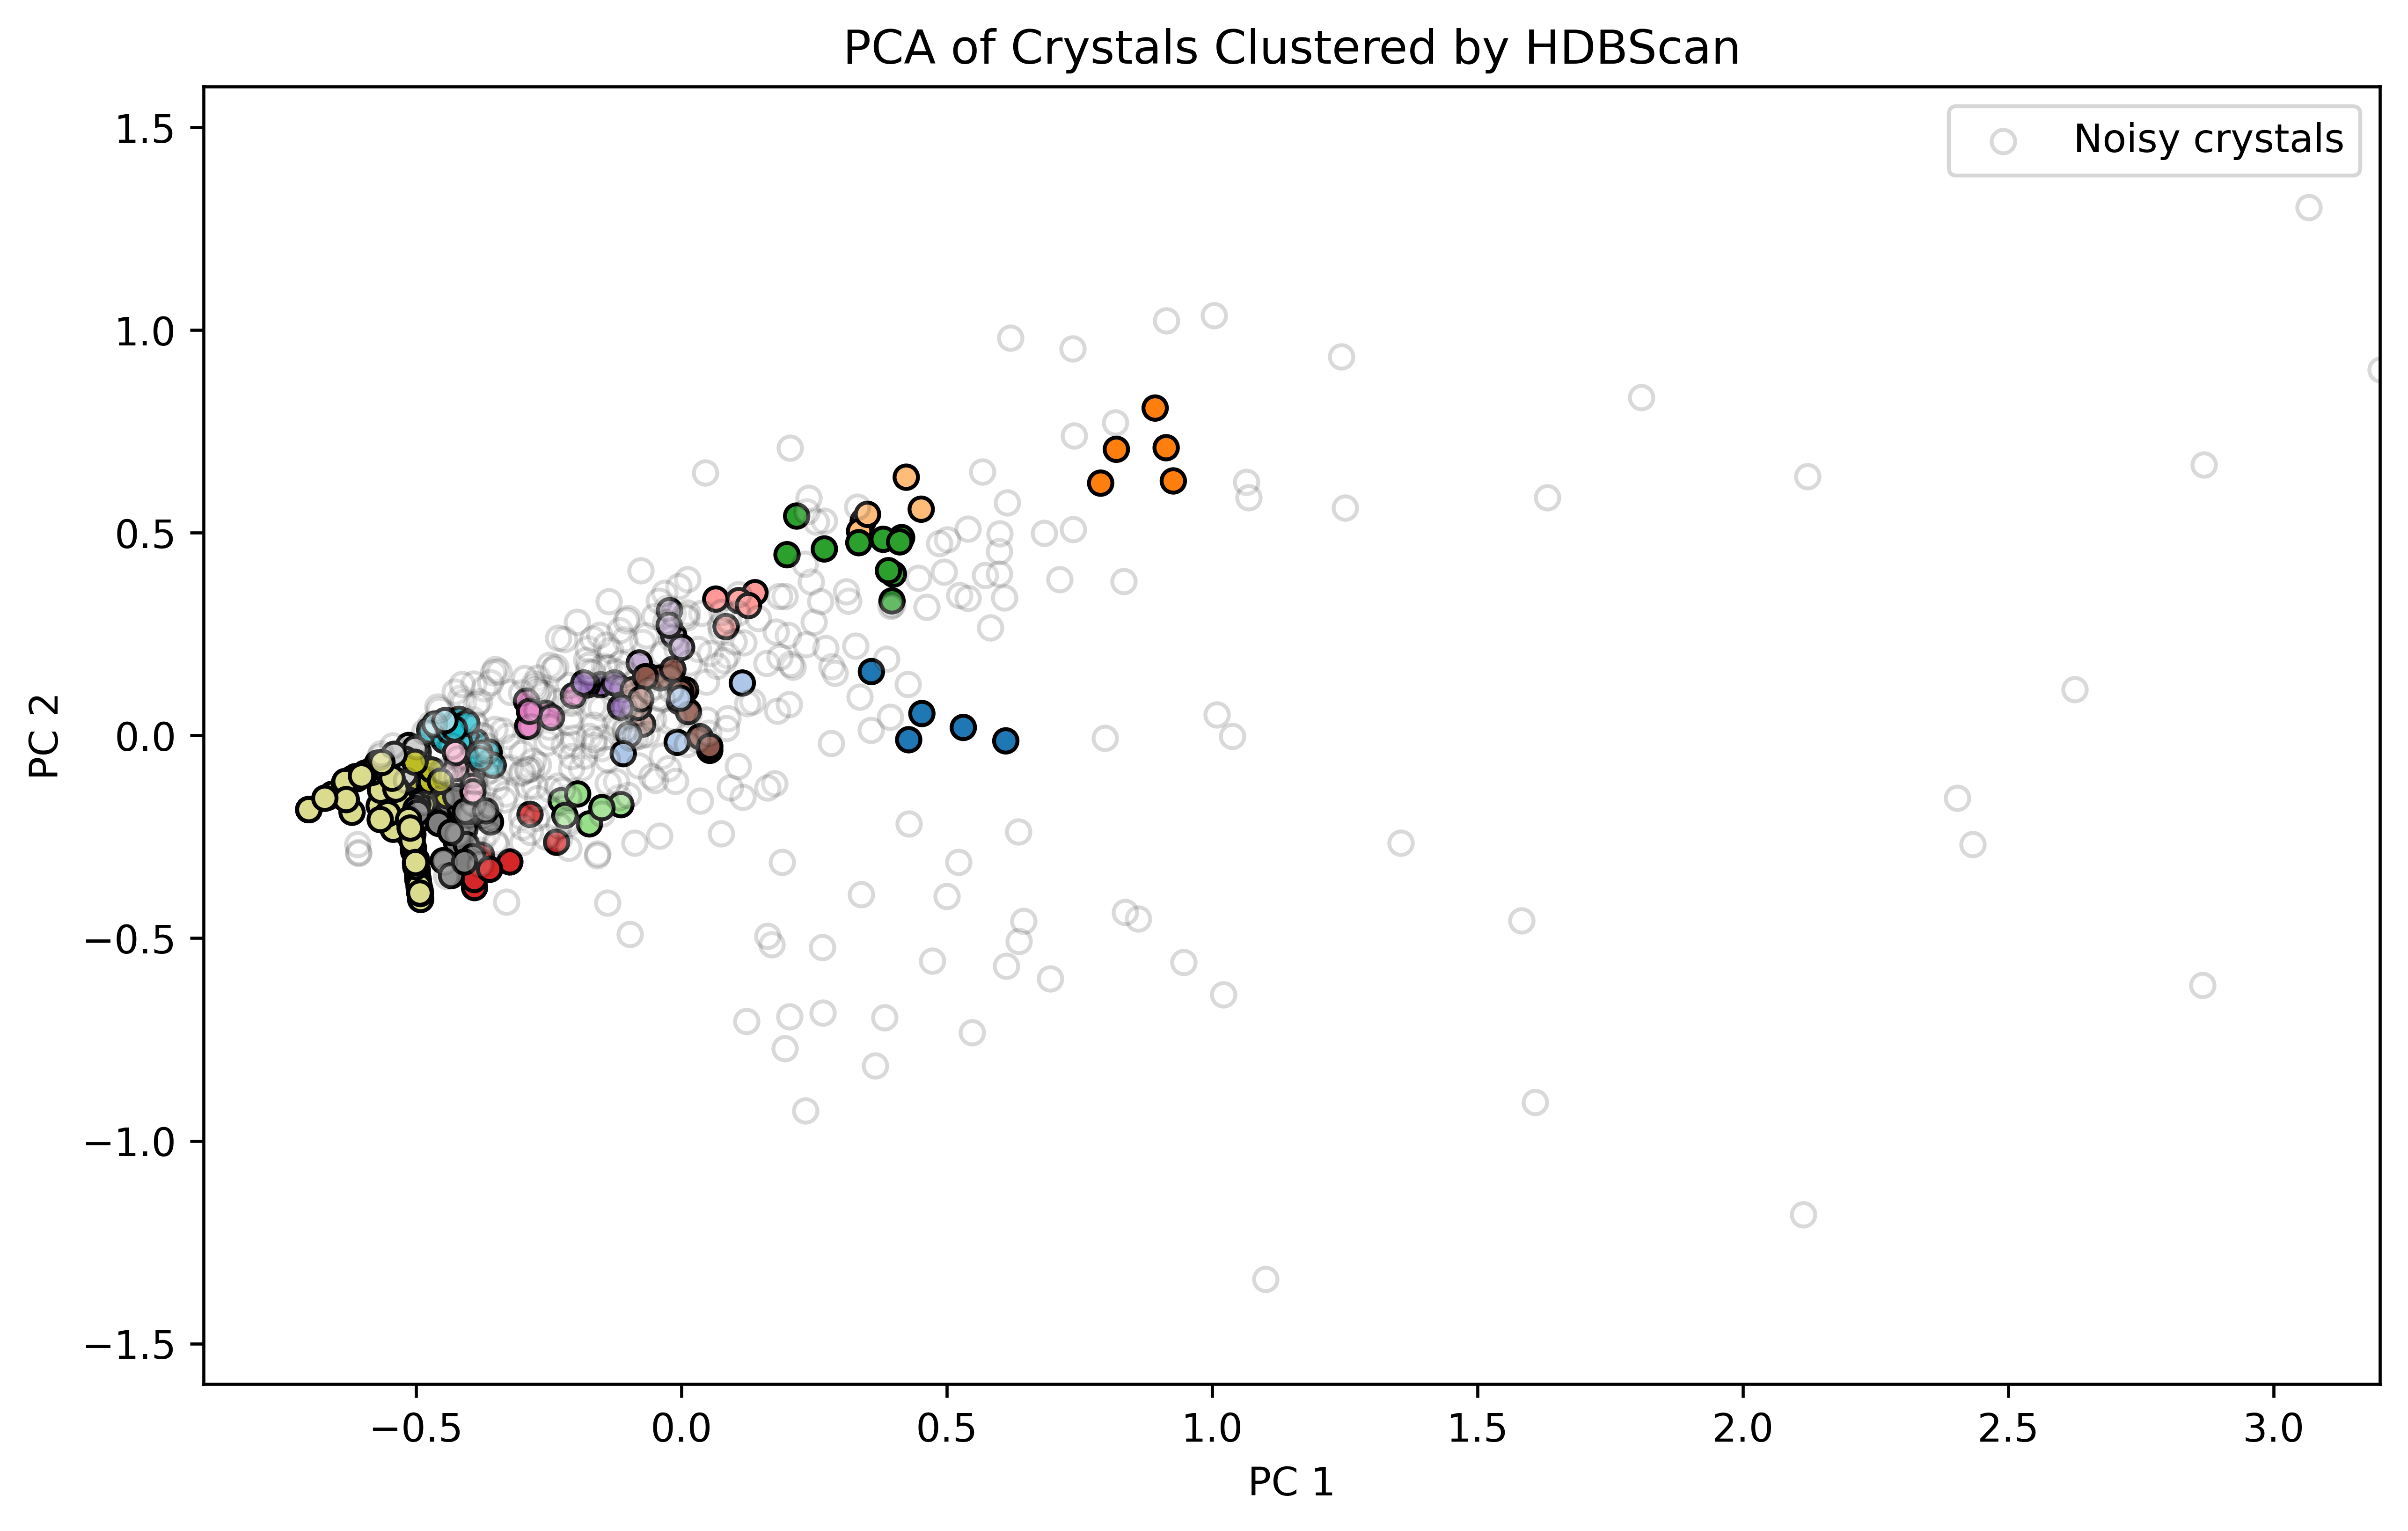

In [46]:
fig, ax = plt.subplots()

ax.scatter(non_noise["pc1"], non_noise["pc2"], c=non_noise["HDB_class"], cmap="tab20", edgecolors="black")
ax.scatter(noise["pc1"], noise["pc2"], c="white", edgecolors="black", alpha=0.15, label="Noisy crystals")

ax.set_ylim((-1.6, 1.6))
ax.set_xlim((-0.9, 3.2))

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

ax.set_title("PCA of Crystals Clustered by HDBScan")

ax.legend()

fig.set_size_inches(10, 6)
fig.set_dpi(600)
fig.savefig("mol_xtal_hdb.png")
fig.show()

/tmp/ipykernel_13936/2113039354.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


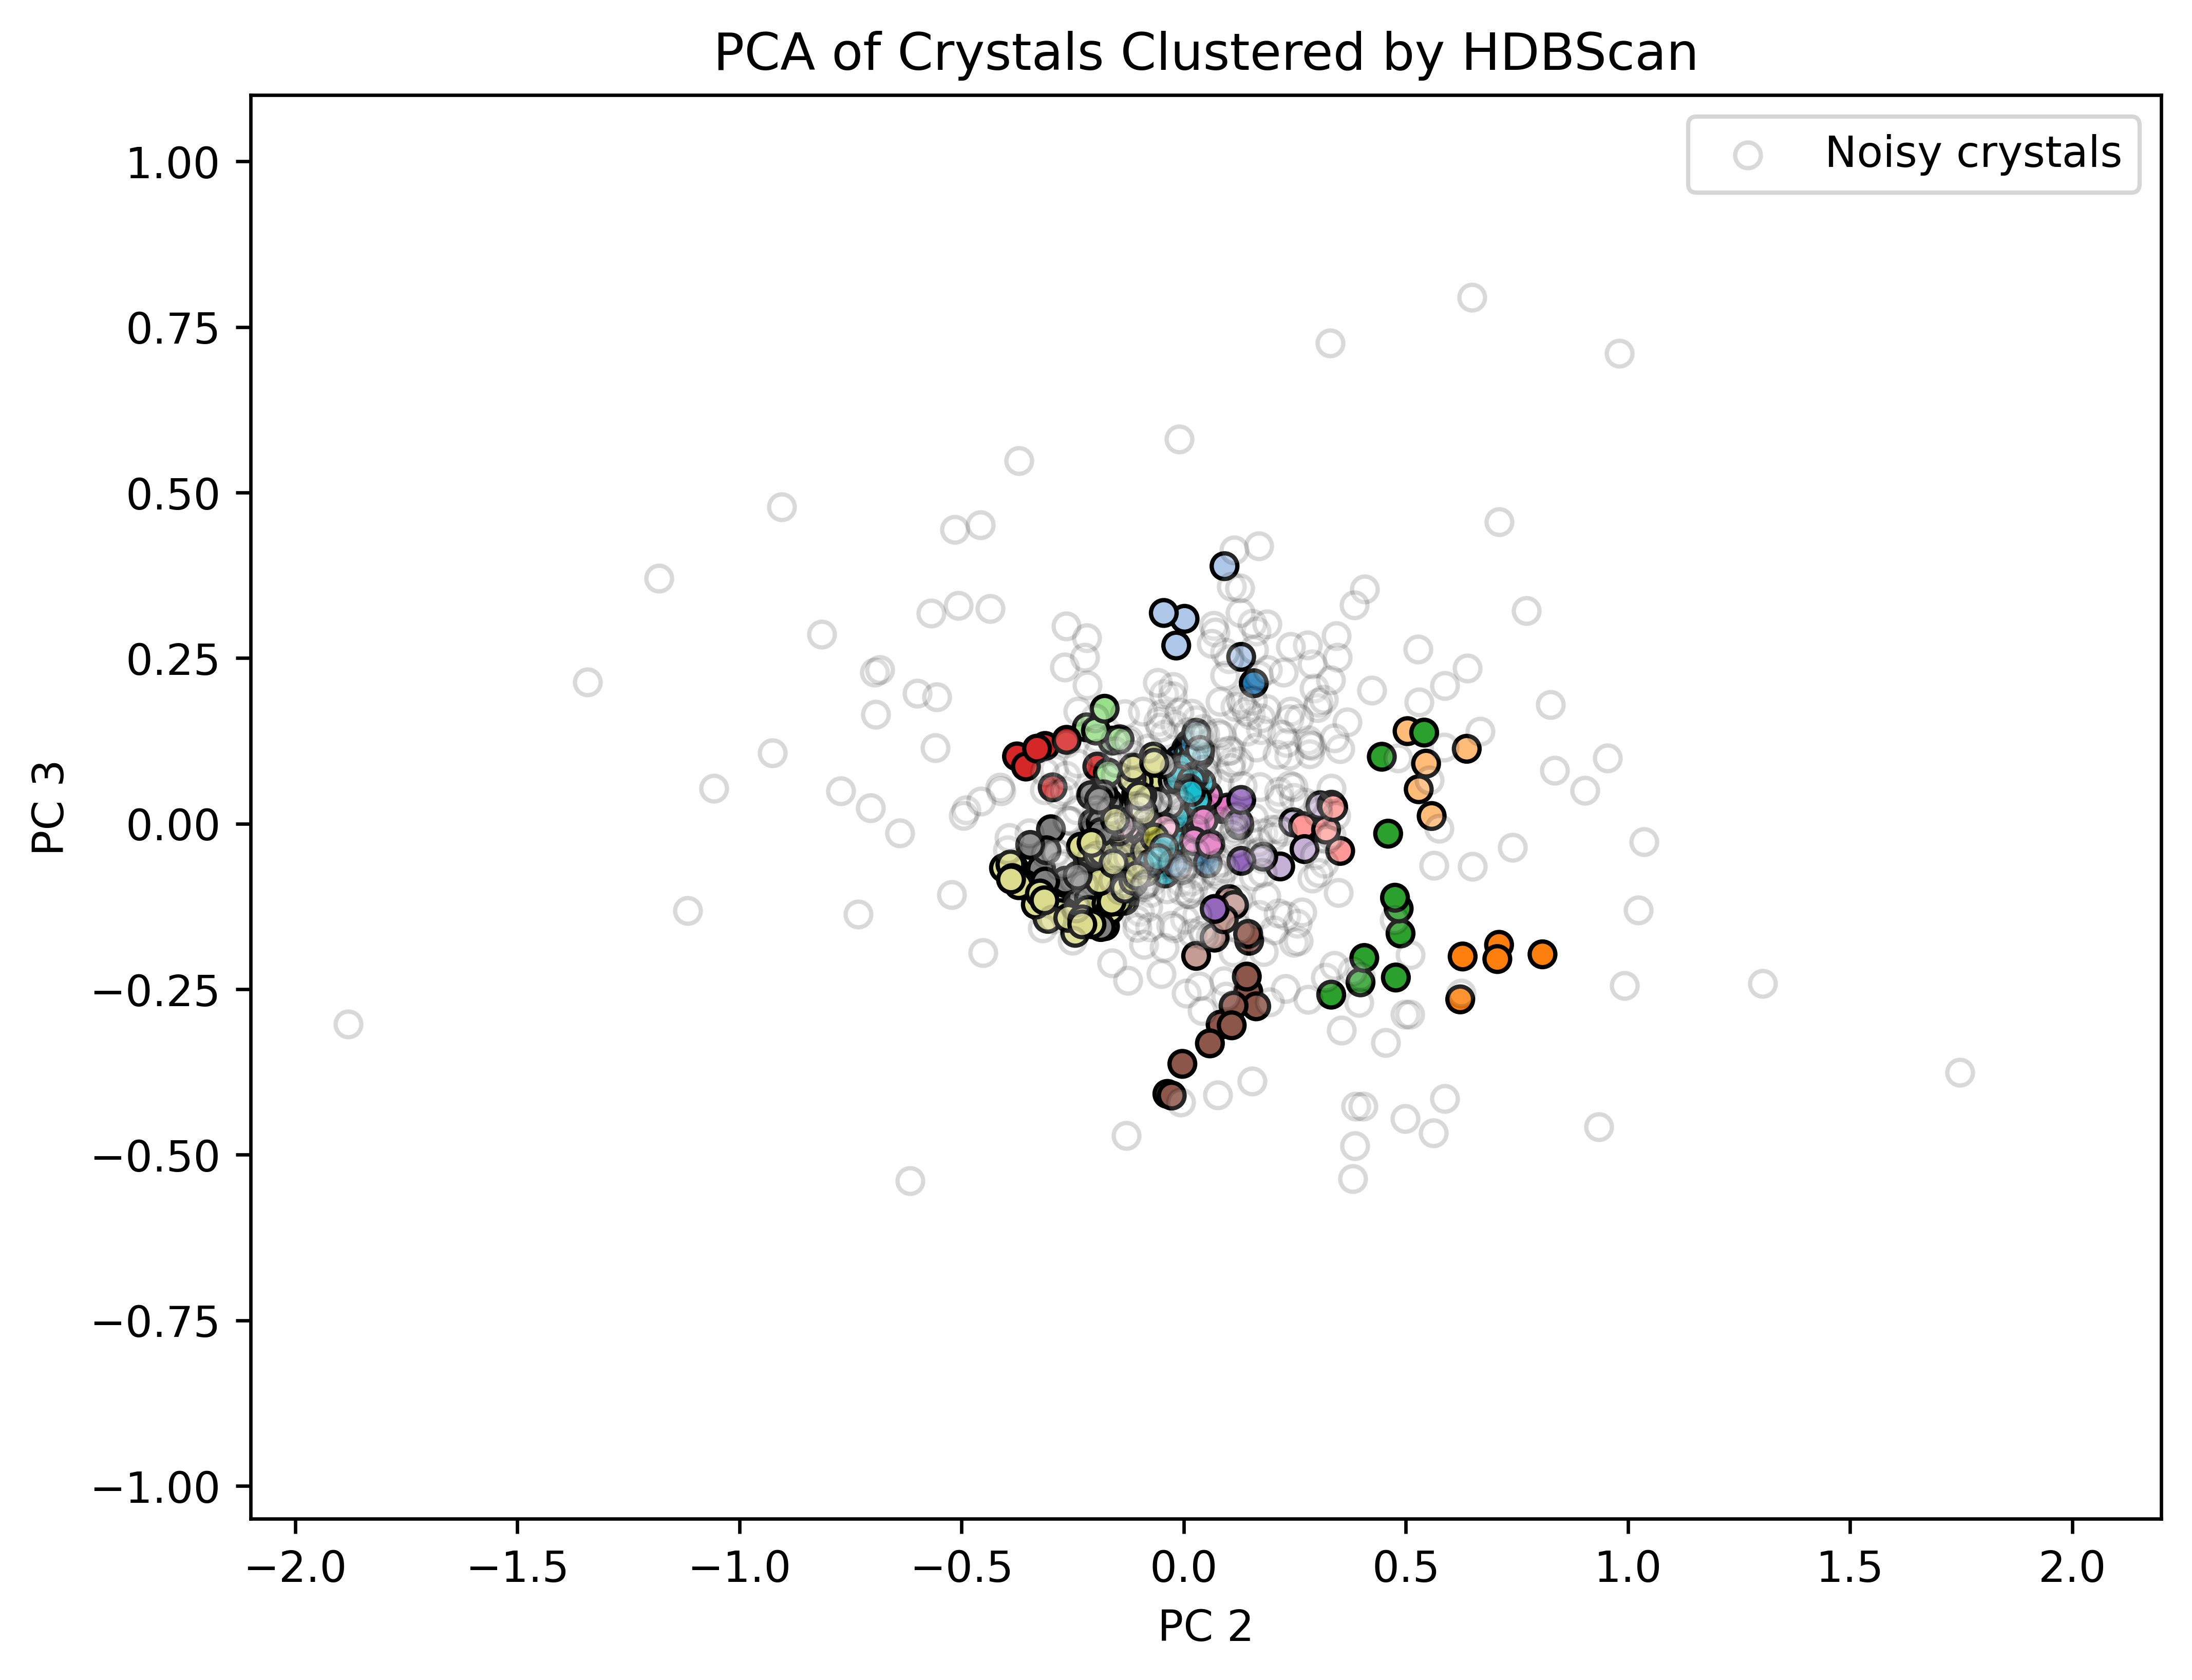

In [47]:
fig, ax = plt.subplots()

ax.scatter(non_noise["pc2"], non_noise["pc3"], c=non_noise["HDB_class"], cmap="tab20", edgecolors="black")
ax.scatter(noise["pc2"], noise["pc3"], c="white", edgecolors="black", alpha=0.15, label="Noisy crystals")

ax.set_ylim((-1.05, 1.1))
ax.set_xlim((-2.1, 2.2))

ax.set_xlabel("PC 2")
ax.set_ylabel("PC 3")

ax.set_title("PCA of Crystals Clustered by HDBScan")

ax.legend()

fig.set_size_inches(8, 6)
fig.set_dpi(600)
fig.savefig("mol_xtal_hdb_pc2pc3.png")
fig.show()

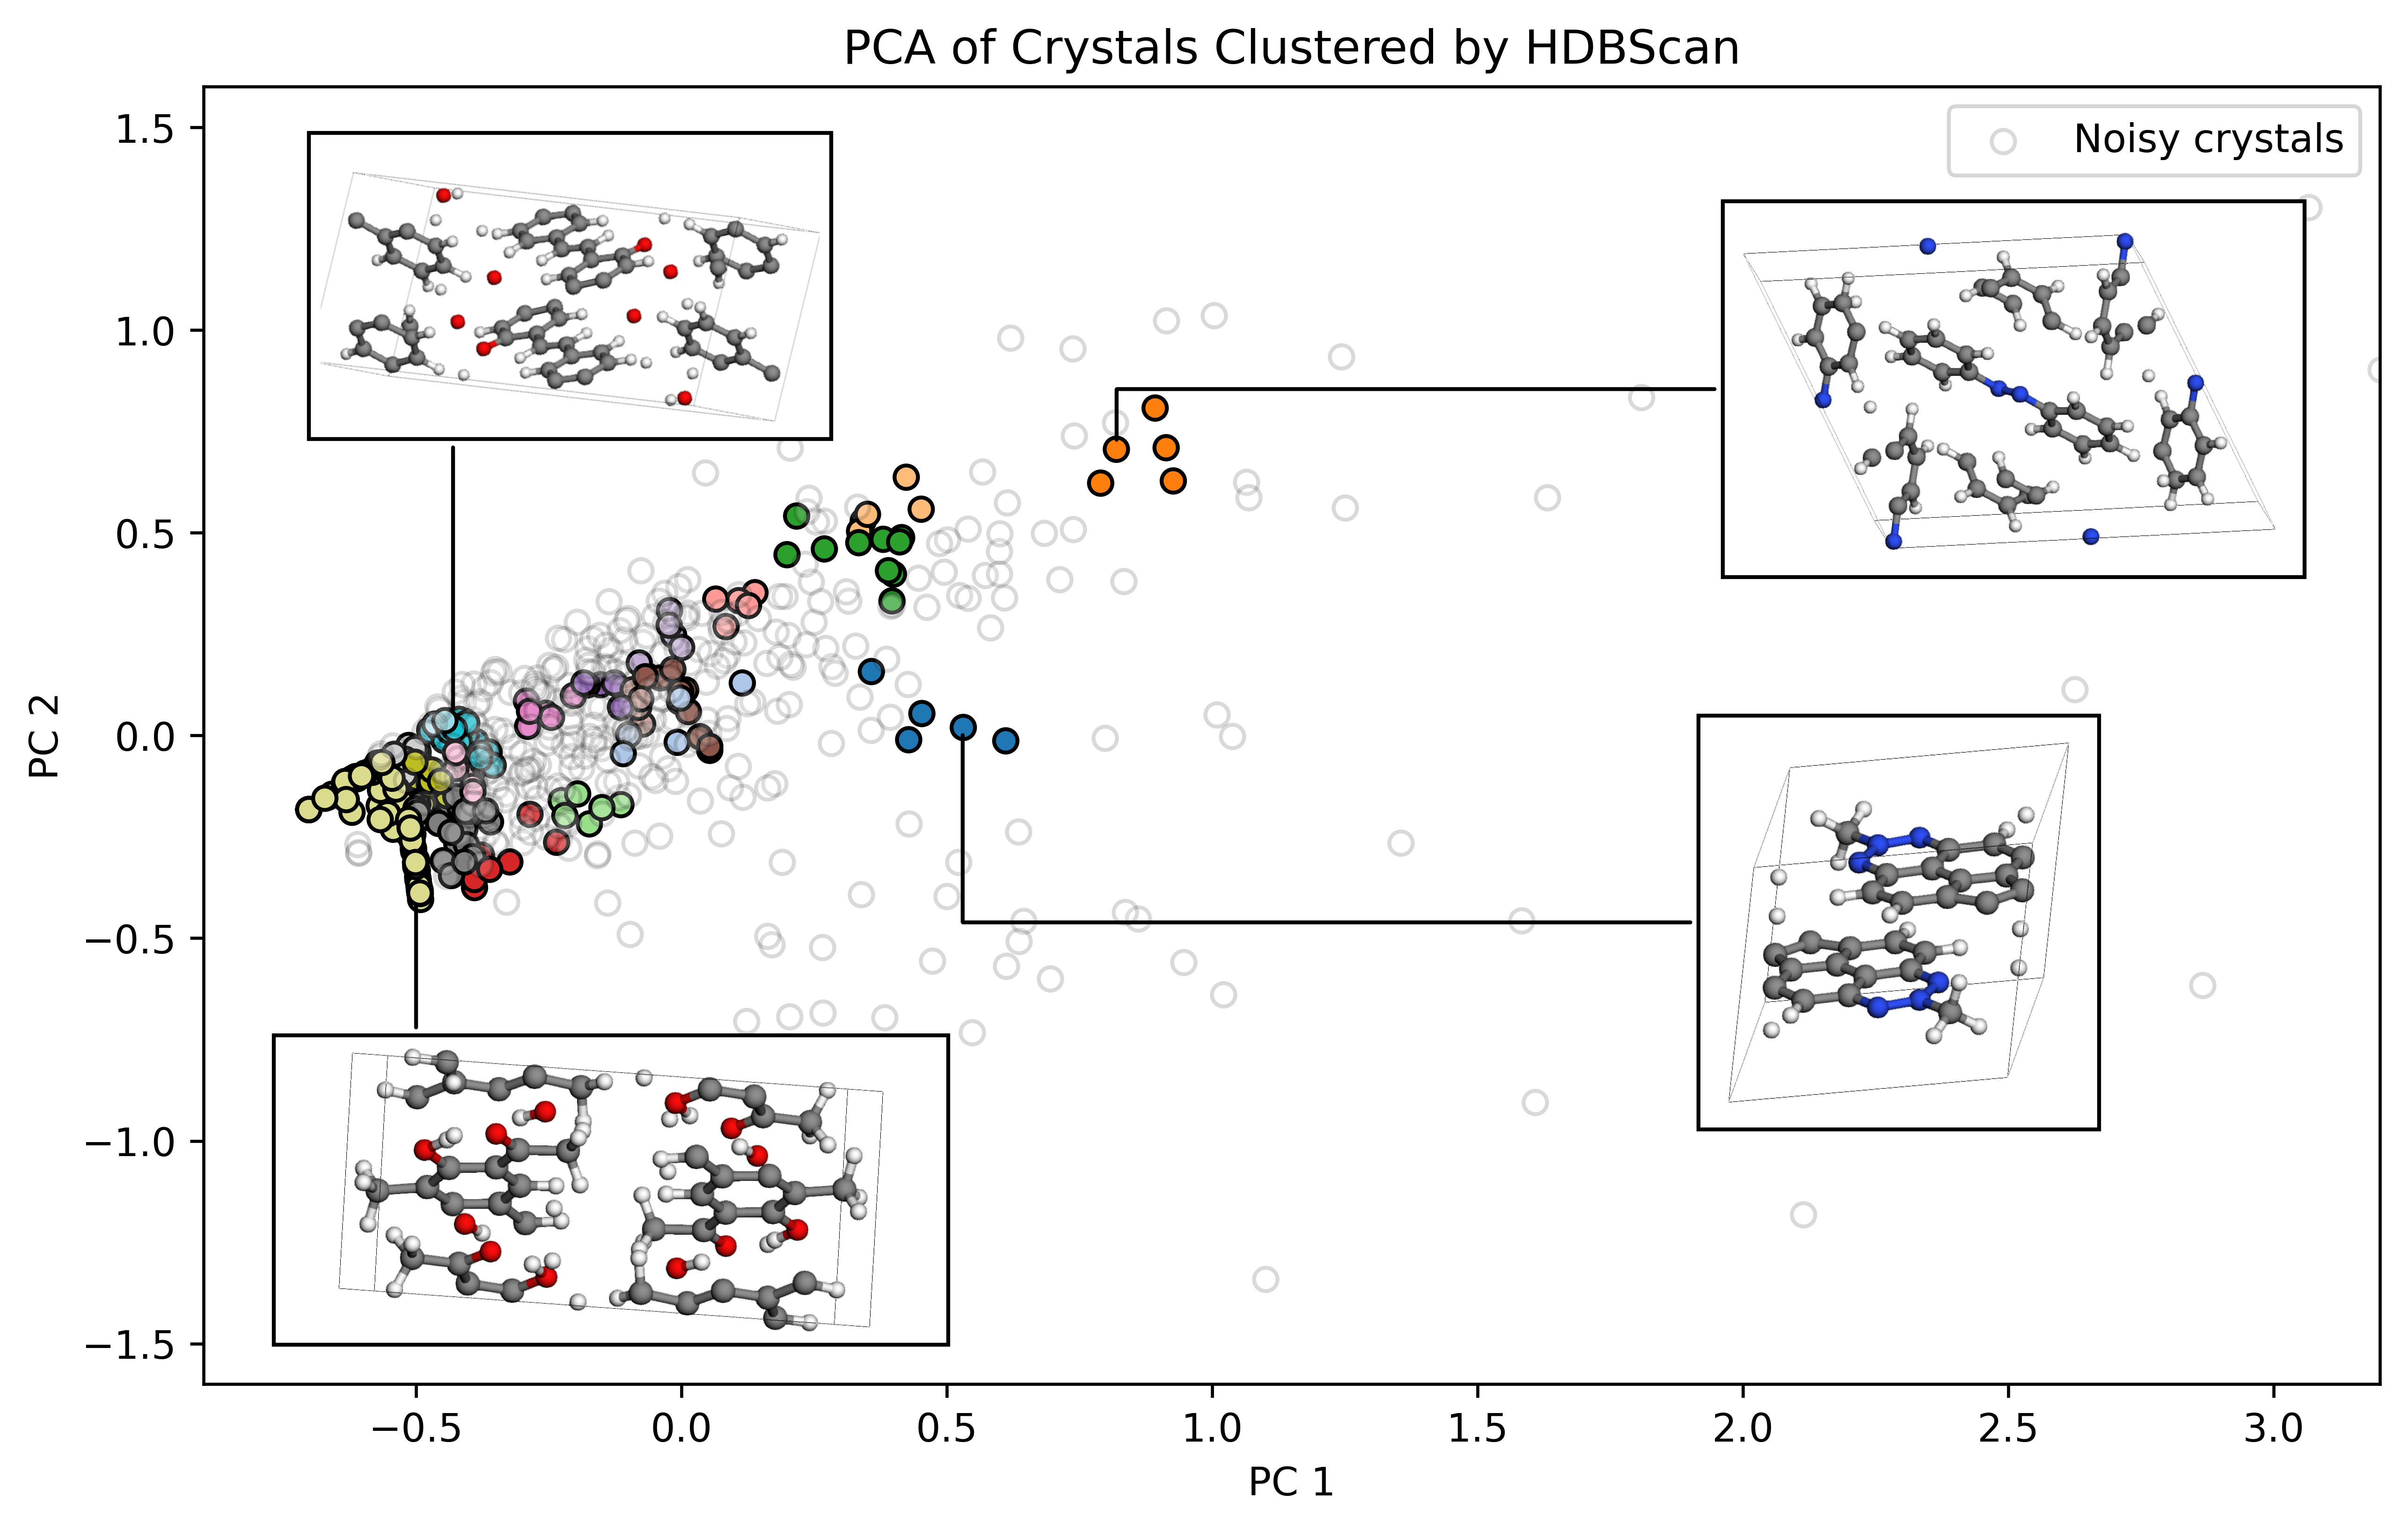

In [28]:

fig, ax = plt.subplots()

ax.scatter(non_noise["pc1"], non_noise["pc2"], c=non_noise["HDB_class"], cmap="tab20", edgecolors="black")
ax.scatter(noise["pc1"], noise["pc2"], c="white", edgecolors="black", alpha=0.15, label="Noisy crystals")

ax.set_ylim((-1.6, 1.6))
ax.set_xlim((-0.9, 3.2))

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

ax.set_title("PCA of Crystals Clustered by HDBScan")

ax.legend()

# Adding lower left structure annotation
xy = (-0.5, -0.4)

with open("chemiscope-structure-112.png", "rb") as file:
    arr_img = plt.imread(file)

imagebox = OffsetImage(arr_img, zoom=0.13)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, xy,
                    xybox=(50., -75),
                    xycoords="data",
                    boxcoords="offset points",
                    pad=0.3,
                    arrowprops=dict(
                        arrowstyle="-",
                        connectionstyle="angle,angleA=0,angleB=90,rad=1"
                    )
                    )

ax.add_artist(ab)

# Adding upper left structure annotation
xy = (-0.43, 0.05)

with open("chemiscope-structure-145.png", "rb") as file:
    arr_img = plt.imread(file)

imagebox = OffsetImage(arr_img, zoom=0.16)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, xy,
                    xybox=(30., 110),
                    xycoords="data",
                    boxcoords="offset points",
                    pad=0.3,
                    arrowprops=dict(
                        arrowstyle="-",
                        connectionstyle="angle,angleA=0,angleB=90,rad=1"
                    )
                    )

ax.add_artist(ab)

# Adding upper right structure annotation
xy = (0.82, 0.71)

with open("chemiscope-structure-36.png", "rb") as file:
    arr_img = plt.imread(file)

imagebox = OffsetImage(arr_img, zoom=0.13)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, xy,
                    xybox=(230., 15),
                    xycoords="data",
                    boxcoords="offset points",
                    pad=0.3,
                    arrowprops=dict(
                        arrowstyle="-",
                        connectionstyle="angle,angleA=0,angleB=90,rad=1"
                    )
                    )

ax.add_artist(ab)

# Adding lower right structure annotation
xy = (0.53, 0.02)

with open("chemiscope-structure-130.png", "rb") as file:
    arr_img = plt.imread(file)

imagebox = OffsetImage(arr_img, zoom=0.14)
imagebox.image.axes = ax

ab = AnnotationBbox(imagebox, xy,
                    xybox=(240., -50),
                    xycoords="data",
                    boxcoords="offset points",
                    pad=0.3,
                    arrowprops=dict(
                        arrowstyle="-",
                        connectionstyle="angle,angleA=0,angleB=90,rad=1"
                    )
                    )

ax.add_artist(ab)

fig.set_size_inches(10, 6)
fig.set_dpi(600)
fig.savefig("mol_xtal_hdb_w_structures.png")

In [38]:
print(xtals[0].info)

{'dft_energy_ryd': np.float64(-796.980802), 'dft_cohesive_energy_relaxed_configs_ryd': np.float64(-0.34021192000000156), 'mol_indices': np.int64(9), 'crystal_idx': np.int64(8), 'CCDC_ID': 'WOGMIQ'}


In [39]:
pc1 = pcs[:, 0]
pc2 = pcs[:, 1]
pc3 = pcs[:, 2]
for i, xtal in enumerate(xtals):
    xtal.info["pc1"] = pc1[i]
    xtal.info["pc2"] = pc2[i]
    xtal.info["pc3"] = pc3[i]
    xtal.info["HDB_class"] = df["HDB_class"].iloc[i]
    xtal.info["ell_count"] = df["ell_count"].iloc[i]
    xtal.info["ell_density"] = df["ell_density"].iloc[i]
    assert xtal.info["CCDC_ID"] == df["CCDC_ID"].iloc[i]

print(xtals[0].info)

{'dft_energy_ryd': np.float64(-796.980802), 'dft_cohesive_energy_relaxed_configs_ryd': np.float64(-0.34021192000000156), 'mol_indices': np.int64(9), 'crystal_idx': np.int64(8), 'CCDC_ID': 'WOGMIQ', 'pc1': np.float64(-0.07689467741417702), 'pc2': np.float64(0.40701117873696896), 'pc3': np.float64(0.35414112939037545), 'HDB_class': np.int64(-1), 'ell_count': np.int64(4), 'ell_density': np.float64(0.004653949470028145)}


In [40]:
chemiscope.write_input(
    "ocsp_anisoap.json",
    frames=xtals,
    properties=chemiscope.extract_properties(
        xtals,
        only=["dft_energy_ryd", "pc1", "pc2", "pc3", "HDB_class", "ell_count", "ell_density"]
    ),
    meta=dict(name="AniSOAP PCA"),
    settings=chemiscope.quick_settings(
        x="pc1", y="pc2", color="HDB_class", size="ell_density"
    ),
)

In [41]:
clustered_xtals = [xtal for xtal in xtals if xtal.info["HDB_class"] != -1]
chemiscope.write_input(
    "only_clustered_xtals.json",
    frames=clustered_xtals,
    properties=chemiscope.extract_properties(
        clustered_xtals,
        only=["dft_energy_ryd", "pc1", "pc2", "pc3", "HDB_class", "ell_count", "ell_density"]
    ),
    meta=dict(name="Clustered points"),
    settings=chemiscope.quick_settings(
        x="pc1", y="pc2", color="HDB_class", size="ell_density"
    ),
)